In [1]:
import tessreduce as tr
import matplotlib.pyplot as plt
import numpy as np

%matplotlib widget
from PRF import TESS_PRF
from scipy.ndimage import center_of_mass

from photutils.detection import StarFinder
from photutils.detection import DAOStarFinder
from astropy.stats import sigma_clipped_stats
from copy import deepcopy

In [3]:
#obs = tr.spacetime_lookup(278.313,62.532,time=58951.38)
#obs = tr.spacetime_lookup(278.313,65.532,time=58951.38)

obs = tr.spacetime_lookup(348.79405058163144,-45.32389674857491,time=58951.38)
#obs = tr.spacetime_lookup(88.3584,-66.98103,time=58000+382)

|   Sector | Covers   |   Time difference  |
|          |          |             (days) |
|----------+----------+--------------------|
|        1 | False    |            -599.38 |
|        2 | False    |            -570.38 |
|       28 | False    |             108.62 |
|       68 | False    |            1202.62 |


In [4]:
#tess = tr.tessreduce(obs_list=obs,reduce=True)
#tess = tr.tessreduce(ra=349.93,dec=-47.84,sector=1,plot=False,reduce=True,size=90)
#tess2 = tr.tessreduce(ra=349.93,dec=-47.84,sector=1,plot=False,reduce=True,size=90,sourcehunt=False)
tess = tr.tessreduce(ra=348.79405058163144,dec=-45.32389674857491,sector=1,plot=False,reduce=True,size=90)
#tess = tr.tessreduce(ra = 284.013 , dec = 33.983, sector = 14,plot=False,reduce=True,size=90,calibrate=False)

#tess2 = tr.tessreduce(ra = 284.013 , dec = 33.983, sector = 14,plot=False,reduce=True,size=90,calibrate=False,sourcehunt=False)




getting TPF from TESScut
made reference
7
made source mask
calculating background
background subtracted
Aligning images
!!Re-running for difference image!!
shifting images
7
remade mask
background


PicklingError: Could not pickle the task to send it to the workers.

In [52]:
tess = tr.tessreduce(ra = 284.013 , dec = 33.983, sector = 14,plot=False,reduce=True,size=90,calibrate=False,diff=False)

getting TPF from TESScut


KeyboardInterrupt: 

In [55]:
def corr2_coeff(A, B):
    # Rowwise mean of input arrays & subtract from input arrays themeselves
    A_mA = A - A.mean(1)[:, None]
    B_mB = B - B.mean(1)[:, None]

    # Sum of squares across rows
    ssA = (A_mA**2).sum(1)
    ssB = (B_mB**2).sum(1)

    # Finally get corr coeff
    return np.dot(A_mA, B_mB.T) / np.sqrt(np.dot(ssA[:, None],ssB[None]))

from scipy.stats import pearsonr
def psflike_check(res, data,prf,corlim=0.8,psfdifflim=0.5):
    cors = []
    maxloc = []
    diff = []
    for i in range(len(res)):
        try:
            x = res[i]['xcentroid']
            y = res[i]['ycentroid']

            cut = deepcopy(data)[int(y)-2:int(y)+3,int(x)-2:int(x)+3]
            cut /= np.nansum(cut)
            cm = center_of_mass(cut)
            localpsf = prf.locate(cm[0],cm[1],(5,5))
            localpsf /= np.nansum(localpsf)
            if cut.shape == localpsf.shape:
                #ind = localpsf >= np.sort(localpsf.flatten())[-4]
                ind = localpsf >= np.sort(localpsf.flatten())[len(localpsf.flatten())//2]
                cor = pearsonr(cut[ind].flatten(),localpsf[ind].flatten()).correlation
                cors += [cor]#[np.nanmean(c)]
                locpsf = np.where(np.nanmax(localpsf) == localpsf)
                locdata = np.where(np.nanmax(cut) == cut)
                maxloc += [locpsf == locdata]
                diff += [np.nansum(abs(cut[ind]-localpsf[ind]))]
            else:
                cors += [0]
                maxloc += [False]
                diff += [2]
        except:
            cors += [0]
            maxloc += [False]
            diff += [2]
                
    cors = np.array(cors)
    cors = np.round(cors,2)
    maxloc = np.array(maxloc)
    diff = np.array(diff)
    ind = (cors >= corlim) & (diff < psfdifflim)
    return ind, cors,diff

def spatial_group(result):
    coords  = np.array([result.xint.values,result.yint.values]).T
    d = np.sqrt((result.xcentroid.values[:,np.newaxis] - result.xcentroid.values[np.newaxis,:])**2+ 
               (result.ycentroid.values[:,np.newaxis] - result.ycentroid.values[np.newaxis,:])**2)
    d2 = np.sqrt((result.xcentroid.values-45)**2+ 
               (result.ycentroid.values-45)**2)

    indo = d < 1
    detecs = np.nansum(indo,axis=1)
    positions = np.unique(indo,axis=1)
    counter = 0

    obj = np.zeros(result.shape[0],dtype=int)
    for i in range(positions.shape[1]):
        obj[positions[:,i]] = counter 
        counter += 1
    result['objid'] = obj
    return result
    
def source_detect(tess,corlim=0.8,psfdifflim=0.5):
    
    prf = TESS_PRF(tess.tpf.camera,tess.tpf.ccd,tess.tpf.sector,
                   tess.tpf.column+tess.flux.shape[2]/2,tess.tpf.row+tess.flux.shape[1]/2)
    psf = prf.locate(5,5,(11,11))
    result = None
    for i in range(len(tess.flux)):
        data = tess.flux[i]
        mean, med, std = sigma_clipped_stats(data, sigma=3.0)
        finder = StarFinder(med + 5*std,kernel=psf)
        res = finder.find_stars(deepcopy(data))
        psf_res = finder.find_stars(psf)
        if res is not None:
            res['frame'] = i
            ind, cors,diff = psflike_check(res,data,prf,corlim=corlim,psfdifflim=psfdifflim)
            res['psflike'] = cors
            res['psfdiff'] = diff
            res = res[ind]
            res = res.to_pandas()
            if result is not None:
                result = result.append(res)
            else:
                result = res
    result['xint'] = deepcopy(result['xcentroid'].values).astype(int)
    result['yint'] = deepcopy(result['ycentroid'].values).astype(int)
    ind = (result['xint'].values >5) & (result['xint'].values < data.shape[1]-5) & (result['yint'].values >5) & (result['yint'].values < data.shape[0]-5)
    result = result[ind]
    result = spatial_group(result)
    return result




In [56]:
t = source_detect(tess,.8,.6)

In [57]:
t

id  xcentroid  ycentroid      fwhm  roundness          pa  max_value  \
0    3  73.926373  26.922498  5.949311   0.170319  113.676201   4.757449   
0    1  73.659501  26.919689  5.413876   0.275253  102.053575   3.864150   
0    1  73.837681  26.746604  6.025505   0.220619   81.603080   3.996924   
0    1  73.932016  26.753230  5.324695   0.217408  105.520115   4.991100   
0    1  73.966680  26.645207  5.381285   0.177685   88.106907   4.518540   
..  ..        ...        ...       ...        ...         ...        ...   
1    2  43.851424  46.680310  4.614780   0.162756   83.283657   7.524642   
0    1  44.091581  47.006040  4.731911   0.134019   97.983131   5.907244   
0    1  43.991438  46.998305  4.758137   0.174984   56.959749   6.438122   
0    1  44.037236  47.117022  5.030322   0.081813   17.844679   7.857861   
0    7  41.953106  45.962312  4.467241   0.116921   61.826782   4.514732   

         flux       mag  frame  psflike   psfdiff  xint  yint  objid  
0   35.292888 -3.869218      1     0.91  0.490265    73    26     27  
0   34.651479 -3.849304      8     0.81  0.575865    73    26     27  
0   37.788764 -3.943407     29     0.88  0.342103    73    26     27  
0   34.393104 -3.841178     36     0.84  0.533418    73    26     27  
0   37.023497 -3.921194     43     0.85  0.390644    73    26     27  
..        ...       ...    ...      ...       ...   ...   ...    ...  
1   40.675796 -4.023340    970     0.86  0.422008    43    46     25  
0   47.756241 -4.197575    977     0.82  0.316872    44    47     25  
0   41.889360 -4.055259    982     0.84  0.521818    43    46     25  
0   47.736742 -4.197132    985     0.85  0.499143    44    47     25  
0   36.619946 -3.909294    992     0.80  0.454155    41    45      0  

[333 rows x 15 columns]

In [75]:
i = t['objid'].values == 19
t.iloc[19]

id             1.000000
xcentroid     44.129035
ycentroid     47.057812
fwhm           4.923100
roundness      0.036690
pa            98.231834
max_value     12.500667
flux          65.744658
mag           -4.544651
frame        113.000000
psflike        0.900000
psfdiff        0.317720
xint          44.000000
yint          47.000000
objid         25.000000
Name: 0, dtype: float64

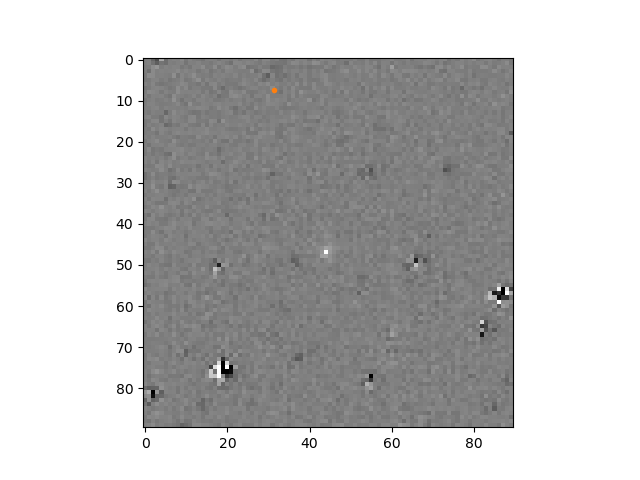

In [74]:
i = t['objid'].values == 19

plt.figure()
plt.imshow(tess.flux[100],vmin=-10,vmax=10,cmap='gray')
plt.plot(t['xcentroid'].values[i],t['ycentroid'].values[i],'C1.')

In [10]:
from scipy.ndimage import correlate as image_correlate

In [60]:
t

id  xcentroid  ycentroid      fwhm  roundness          pa  max_value  \
0    3  73.926373  26.922498  5.949311   0.170319  113.676201   4.757449   
0    1  73.659501  26.919689  5.413876   0.275253  102.053575   3.864150   
0    1  73.837681  26.746604  6.025505   0.220619   81.603080   3.996924   
0    1  73.932016  26.753230  5.324695   0.217408  105.520115   4.991100   
0    1  73.966680  26.645207  5.381285   0.177685   88.106907   4.518540   
..  ..        ...        ...       ...        ...         ...        ...   
1    2  43.851424  46.680310  4.614780   0.162756   83.283657   7.524642   
0    1  44.091581  47.006040  4.731911   0.134019   97.983131   5.907244   
0    1  43.991438  46.998305  4.758137   0.174984   56.959749   6.438122   
0    1  44.037236  47.117022  5.030322   0.081813   17.844679   7.857861   
0    7  41.953106  45.962312  4.467241   0.116921   61.826782   4.514732   

         flux       mag  frame  psflike   psfdiff  xint  yint  objid  
0   35.292888 -3.869218      1     0.91  0.490265    73    26     27  
0   34.651479 -3.849304      8     0.81  0.575865    73    26     27  
0   37.788764 -3.943407     29     0.88  0.342103    73    26     27  
0   34.393104 -3.841178     36     0.84  0.533418    73    26     27  
0   37.023497 -3.921194     43     0.85  0.390644    73    26     27  
..        ...       ...    ...      ...       ...   ...   ...    ...  
1   40.675796 -4.023340    970     0.86  0.422008    43    46     25  
0   47.756241 -4.197575    977     0.82  0.316872    44    47     25  
0   41.889360 -4.055259    982     0.84  0.521818    43    46     25  
0   47.736742 -4.197132    985     0.85  0.499143    44    47     25  
0   36.619946 -3.909294    992     0.80  0.454155    41    45      0  

[333 rows x 15 columns]

In [39]:
cors = []
for i in range(2):
    x = t.iloc[i]['xcentroid']
    y = t.iloc[i]['ycentroid']
    data = tess.flux[int(t.iloc[i]['frame'])]
    cut = deepcopy(data)[int(y)-2:int(y)+3,int(x)-2:int(x)+3]
    cut /= np.nansum(cut)
    cm = center_of_mass(cut)
    localpsf = prf.locate(cm[0],cm[1],(5,5))
    localpsf /= np.nansum(localpsf)

In [28]:
corr2_coeff(cut,localpsf)

array([[-0.42968353, -0.3451549 , -0.32526558, -0.49295111, -0.55776927],
       [ 0.7553381 ,  0.9688482 ,  0.87414039,  0.71619473,  0.80678924],
       [ 0.13913994,  0.72761714,  0.91931362,  0.89460697,  0.79827873],
       [ 0.54158206,  0.94736813,  0.99369226,  0.92183495,  0.92904688],
       [ 0.82423117,  0.96523117,  0.83226303,  0.66902928,  0.78406851]])

In [29]:
np.corrcoef(cut,localpsf)

array([[ 1.        , -0.27210104, -0.14270071, -0.32983531, -0.26305721,
        -0.42968353, -0.3451549 , -0.32526558, -0.49295111, -0.55776927],
       [-0.27210104,  1.        ,  0.67157468,  0.91346506,  0.99214345,
         0.7553381 ,  0.9688482 ,  0.87414039,  0.71619473,  0.80678924],
       [-0.14270071,  0.67157468,  1.        ,  0.90102139,  0.59279283,
         0.13913994,  0.72761714,  0.91931362,  0.89460697,  0.79827873],
       [-0.32983531,  0.91346506,  0.90102139,  1.        ,  0.87095377,
         0.54158206,  0.94736813,  0.99369226,  0.92183495,  0.92904688],
       [-0.26305721,  0.99214345,  0.59279283,  0.87095377,  1.        ,
         0.82423117,  0.96523117,  0.83226303,  0.66902928,  0.78406851],
       [-0.42968353,  0.7553381 ,  0.13913994,  0.54158206,  0.82423117,
         1.        ,  0.77591777,  0.51600355,  0.42456628,  0.62693528],
       [-0.3451549 ,  0.9688482 ,  0.72761714,  0.94736813,  0.96523117,
         0.77591777,  1.        ,  0.93403814

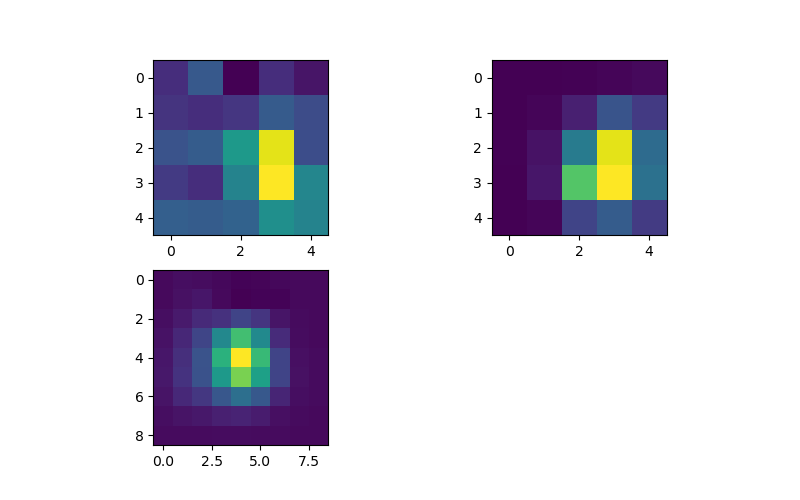

In [37]:
plt.figure(figsize=(8,5))
plt.subplot(221)
plt.imshow(cut)

plt.subplot(222)
plt.imshow(localpsf)

plt.subplot(223)
plt.imshow(correlate2d(cut,localpsf))

In [49]:
np.sort(localpsf.flatten())

array([1.74831763e-04, 2.95705907e-04, 4.97413430e-04, 5.57279536e-04,
       8.52831033e-04, 9.53753614e-04, 1.26965968e-03, 2.75010228e-03,
       3.01760494e-03, 3.14981457e-03, 4.76841456e-03, 9.59829686e-03,
       1.20001752e-02, 1.67092381e-02, 3.29904582e-02, 3.32567269e-02,
       3.95697978e-02, 4.97803618e-02, 5.60920976e-02, 6.67458803e-02,
       7.11329521e-02, 7.93330891e-02, 1.40133205e-01, 1.83246336e-01,
       1.91123974e-01])

In [179]:
ind = localpsf >= np.sort(localpsf.flatten())[len(localpsf.flatten())//2]
cor = pearsonr(cut[ind].flatten(),localpsf[ind].flatten()).correlation

In [52]:
cut[ind]-localpsf[ind]

array([ 0.01085804,  0.00167503, -0.07015441,  0.00303905])

In [81]:
eh = cut[ind].reshape(2,2)
eh[0,0] += .3
eh /= np.sum(eh)

In [93]:
np.correlate(cut[ind],localpsf[ind])

array([0.08795686])

In [95]:
from scipy.signal import fftconvolve

In [98]:
test = fftconvolve(cut,localpsf,mode='same')

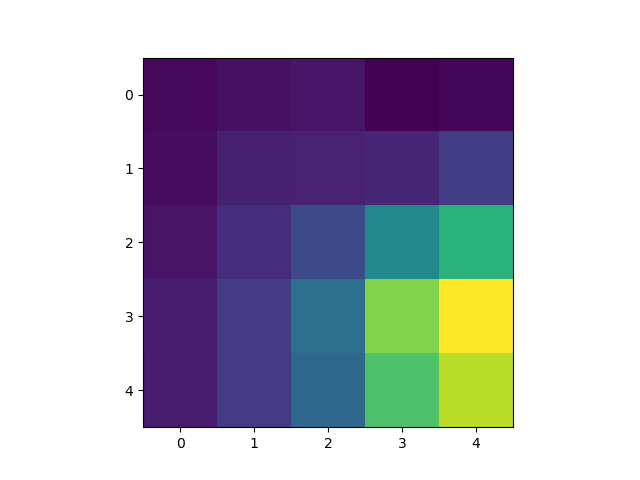

In [99]:
plt.figure()
plt.imshow(test)

In [94]:
cut[ind]-localpsf[ind]

array([ 0.01085804,  0.00167503, -0.07015441,  0.00303905])

In [84]:
corr2_coeff(cut,localpsf)

array([[-0.42968353, -0.3451549 , -0.32526558, -0.49295111, -0.55776927],
       [ 0.7553381 ,  0.9688482 ,  0.87414039,  0.71619473,  0.80678924],
       [ 0.13913994,  0.72761714,  0.91931362,  0.89460697,  0.79827873],
       [ 0.54158206,  0.94736813,  0.99369226,  0.92183495,  0.92904688],
       [ 0.82423117,  0.96523117,  0.83226303,  0.66902928,  0.78406851]])

In [85]:
corr2_coeff(eh,localpsf[ind].reshape(2,2))

array([[-1., -1.],
       [ 1.,  1.]])

In [80]:
localpsf[ind].reshape(2,2)

array([[0.07933309, 0.18324634],
       [0.1401332 , 0.19112397]])

In [63]:
cut[ind].reshape(2,2)

array([[0.09019113, 0.18492136],
       [0.0699788 , 0.19416302]])

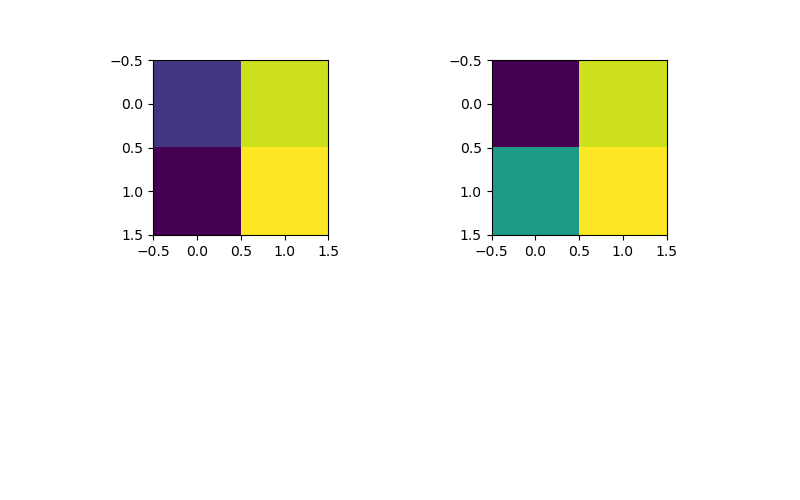

In [60]:
plt.figure(figsize=(8,5))
plt.subplot(221)
plt.imshow(cut[ind].reshape(2,2))

plt.subplot(222)
plt.imshow(localpsf[ind].reshape(2,2))

In [169]:
from scipy.signal import correlate2d
from scipy.stats import pearsonr

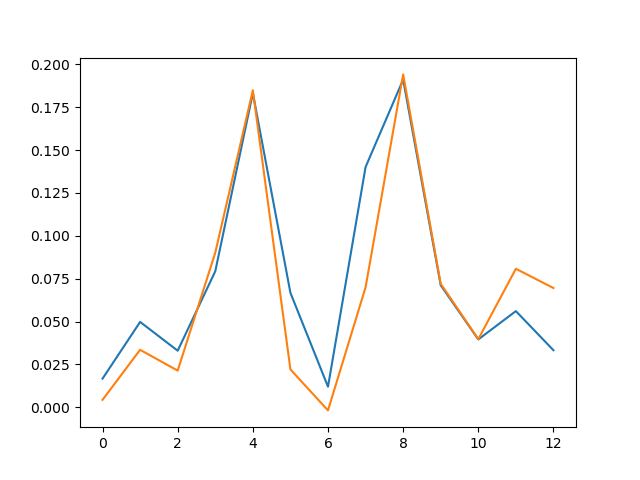

In [180]:
plt.figure()
plt.plot(localpsf[ind].flatten())
plt.plot(cut[ind].flatten())

0.8974604980523796

In [59]:
image_correlate(cut,localpsf)

array([[0.01078994, 0.01150282, 0.01863958, 0.01336608, 0.01256689],
       [0.0203666 , 0.04771533, 0.07269138, 0.05337622, 0.04349368],
       [0.0253227 , 0.06655122, 0.10575302, 0.07975366, 0.07220198],
       [0.03008441, 0.06213176, 0.09261667, 0.07910157, 0.08163291],
       [0.03273687, 0.05577361, 0.07936644, 0.07847899, 0.08113046]])

In [16]:
t.iloc[i]['frame']

15.0

In [117]:
cat = tess.cat.sort_values('rmag')

x = cat['col'].values
y = cat['row'].values
indo = cat.rmag < 12.5

NameError: name 'indo' is not defined

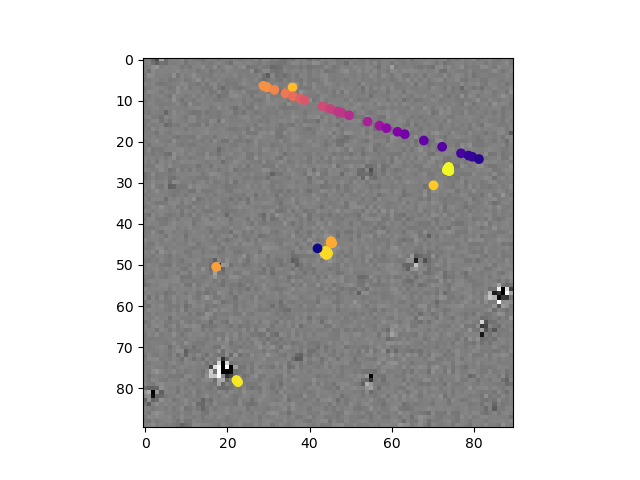

In [59]:


plt.figure()
plt.imshow(tess.flux[100],vmin=-10,vmax=10,cmap='gray')
#plt.plot(res2['xcentroid'],res2['ycentroid'],'C1.')
plt.scatter(t['xcentroid'],t['ycentroid'],c=t['objid'],cmap='plasma')
plt.scatter(x[indo],y[indo])

In [1049]:
from sys import path 
path.append('/Users/rri38/Documents/work/code/dart')
from find_asteroid import MPCquery

In [1058]:
for i in np.unique(t.objid.values):
    ind = t.objid.values == i
    obj = t.iloc[ind]
    x = np.mean(obj.xint.values); y = np.mean(obj.yint.values)
    ra, dec = tess.wcs.all_pix2world(x,y,0)
    jd = tess.lc[0,int(np.nanmedian(obj.frame.values))] + 2400000.5
    results = MPCquery(ra,dec,jd,10,obscode='C57',limit=str(20))
    asdf

NameError: name 'asdf' is not defined

In [1060]:
results

name          RA        Dec     V
0  (1591) Baize  23 14 20.0  -45 24 48  14.6
1

In [ ]:
results = MPCquery(ra,dec,epoch,radius*60,obscode=obscode,limit=str(maglim))

In [1056]:
jd = tess.lc[0,int(np.nanmedian(obj.frame.values))] + 2400000.5

In [1057]:
jd

2458346.828243428

!!! 0
8


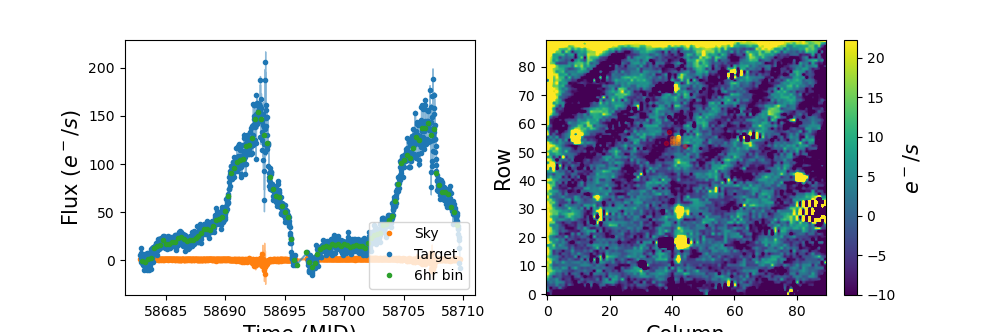

In [195]:
for i in np.unique(t.objid.values):
    ind = t.objid.values == i
    obj = t.iloc[ind]
    print('!!!',i)
    print(len(obj))
    x = int(np.mean(obj.xint.values)); y = int(np.mean(obj.yint.values))
    tess.diff_lc(x=x,y=y,plot=True)

In [988]:
ind = t['objid'].values == 110

In [995]:
tess.wcs.all_pix2world(t.xcentroid.iloc[ind].values[0],t.ycentroid.iloc[ind].values[0],0)

[array(284.10084544), array(34.03751951)]

In [994]:
max(t.objid.values)

132

In [992]:
t.xcentroid.iloc[ind][0][0]

0    29.065804
0    29.120964
0    29.120453
Name: xcentroid, dtype: float64

In [855]:
coords  = np.array([res2.xint.values,res2.yint.values]).T

In [998]:
d = np.sqrt((t.xcentroid.values[:,np.newaxis] - t.xcentroid.values[np.newaxis,:])**2+ 
           (t.ycentroid.values[:,np.newaxis] - t.ycentroid.values[np.newaxis,:])**2)
d2 = np.sqrt((t.xcentroid.values-45)**2+ 
           (t.ycentroid.values-45)**2)

indo = d < 1
detecs = np.nansum(indo,axis=1)
positions = np.unique(indo,axis=1)

In [198]:
mean, med, std = sigma_clipped_stats(tess.ref)

In [1]:
lim = med + 10* std
ref = deepcopy(tess.ref)
ind = ref > lim

ref[ind] = np.nan

tester = deepcopy(tess)

mask = np.ones_like(tester.ref)
mask[ind] = np.nan
tester.flux = tester.flux * mask

plt.figure()
plt.subplot(121)
#plt.scatter(x[indo],y[indo])
plt.imshow(tess.ref,vmax=100)

plt.subplot(122)
#plt.scatter(x[indo],y[indo])
plt.imshow(tester.flux[100],vmin=-10,vmax=10)
plt.tight_layout()

NameError: name 'med' is not defined

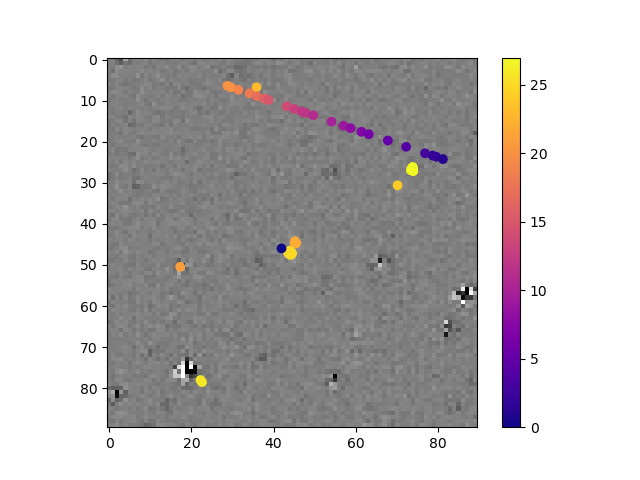

In [72]:
plt.figure()
plt.imshow(tess.flux[100],vmin=-10,vmax=10,cmap='gray')
#plt.plot(res2['xcentroid'],res2['ycentroid'],'C1.')
plt.scatter(t['xcentroid'],t['ycentroid'],c=t['objid'],cmap='plasma')
plt.colorbar()

!!! 1
3


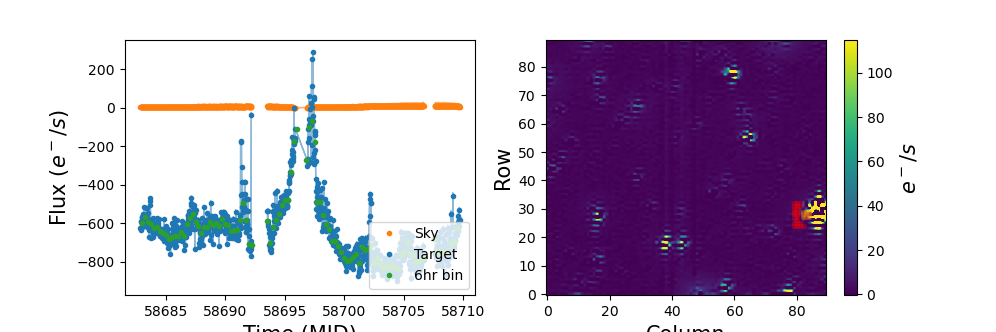

!!! 2
1


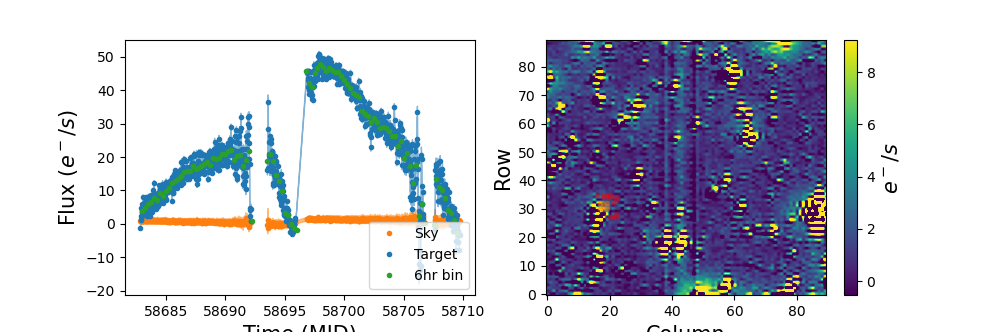

!!! 3
4


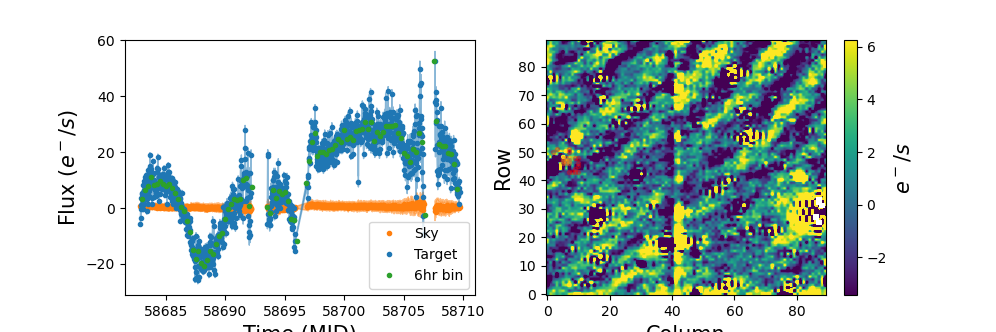

!!! 4
1


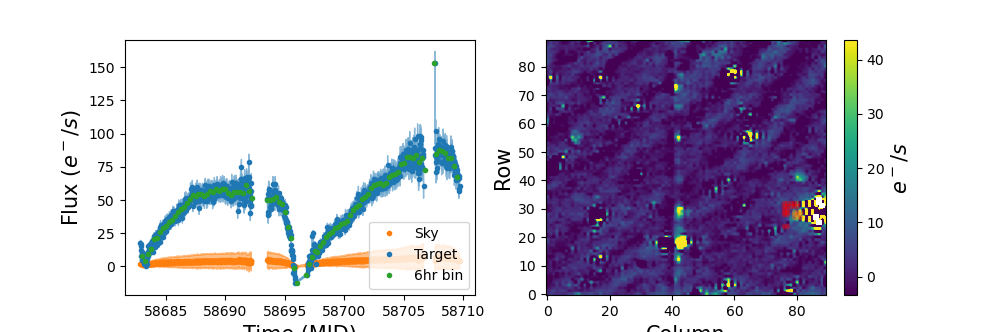

!!! 7
1


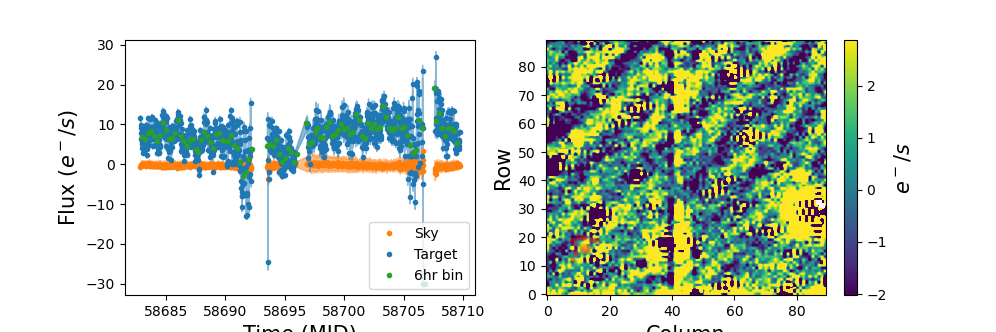

!!! 11
1


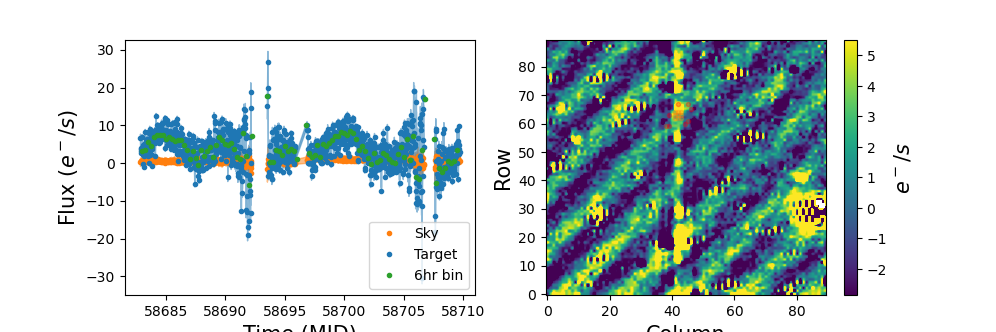

!!! 12
1


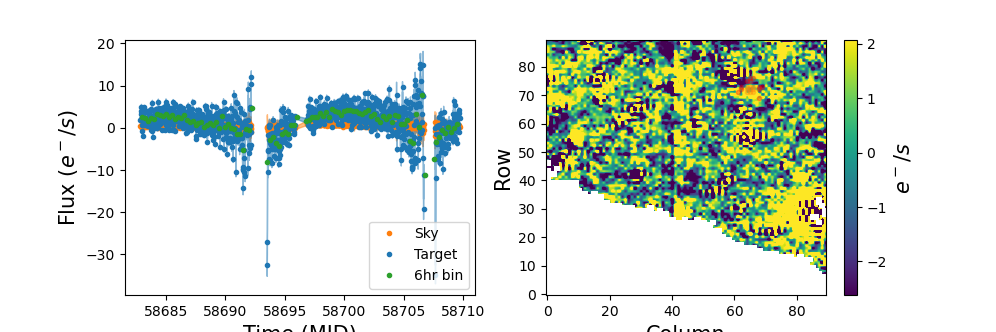

!!! 13
1


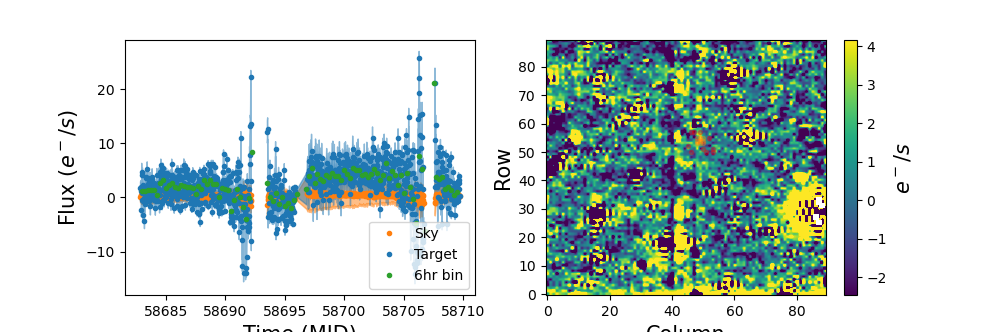

!!! 14
2


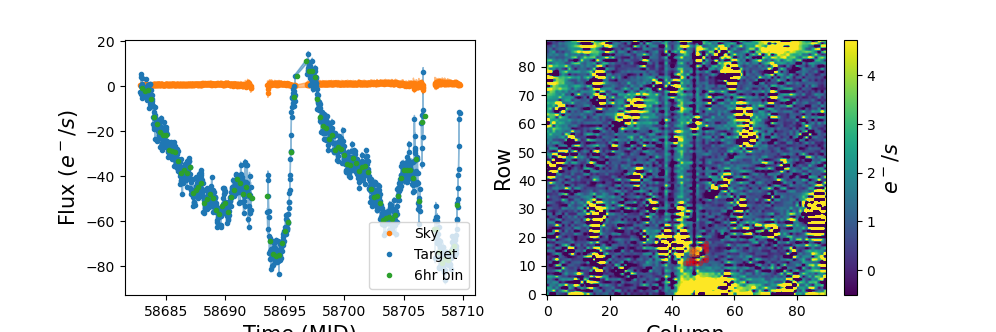

!!! 15
1


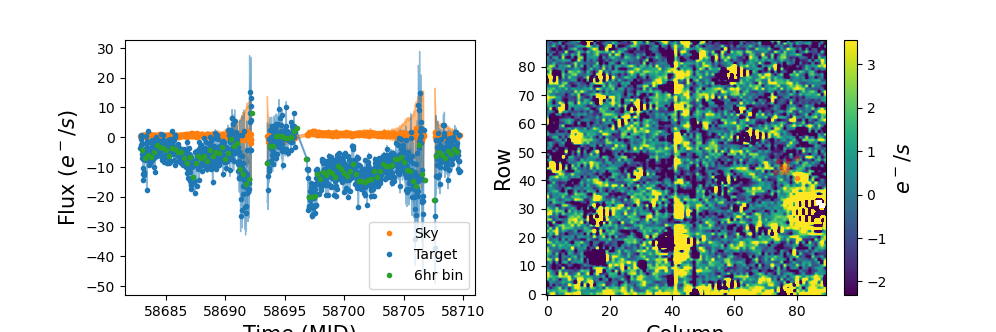

In [1018]:
for i in np.unique(t2.objid.values)[:10]:
    ind = t2.objid.values == i
    obj = t2.iloc[ind]
    print('!!!',i)
    print(len(obj))
    x = int(np.mean(obj.xint.values)); y = int(np.mean(obj.yint.values))
    tkill.diff_lc(x=x,y=y,plot=True)

In [787]:
counter = 1

obj = np.zeros(res2.shape[0])
for i in range(positions.shape[1]):
    obj[positions[:,i]] = counter 
    counter += 1
res2['objid'] = obj

In [418]:
cors = []
for i in range(len(res)):
    x = res[i]['xcentroid']
    y = res[i]['ycentroid']

    cut = deepcopy(data)[int(y)-1:int(y)+2,int(x)-1:int(x)+2]
    cut /= np.nansum(cut)

    localpsf = prf.locate(x-int(x)+1,y-int(y)+1,(3,3))
    thing /= np.nansum(localpsf)
    cors += [np.nanmean(corr2_coeff(cut,localpsf))]
cors = np.array(cors)
cors = np.round(cors,2)
ind = cors >= 0.8

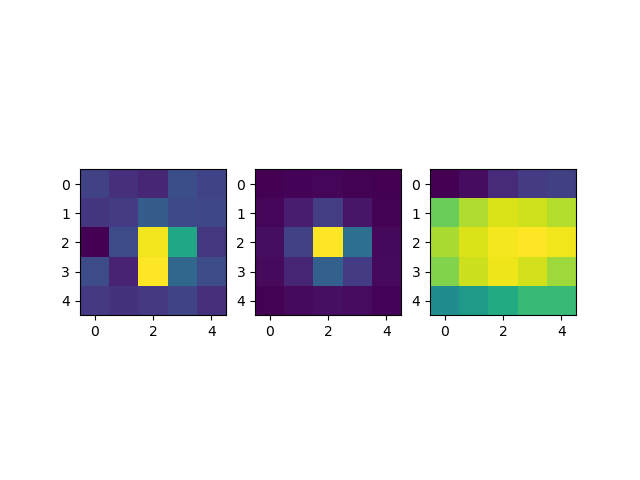

In [666]:
i = 98
x = res2[indo[i]]['xcentroid'].values[0]
y = res2[indo[i]]['ycentroid'].values[0]
eh = res2[indo[i]]['frame'].values[0]
#eh = 1110

cut = (deepcopy(tess.flux[eh])[int(y)-2:int(y)+3,int(x)-2:int(x)+3])
cut /= np.nansum((cut))

localpsf = prf.locate(x-int(x)+2,y-int(y)+2,(5,5))
thing /= np.nansum(localpsf)
cors = corr2_coeff(cut,localpsf)

print()
plt.figure()
plt.subplot(131)
plt.imshow(cut)
plt.subplot(132)
plt.imshow(localpsf)
plt.subplot(133)
plt.imshow(cors)

In [667]:
np.average(cors,weights=localpsf)

0.856233695258508

In [669]:
np.nansum(abs(cut-localpsf))

1.028462002995567

In [668]:

np.mean(cors)

0.4236042944038952

In [616]:
l1 = []
l2 = []
for i in range(2):
    if i == 1:
        locdata = (np.array([1]),np.array([1]))
        locpsf = np.where(np.nanmax(localpsf) == localpsf)
    else:
        locpsf = np.where(np.nanmax(localpsf) == localpsf)
        locdata = np.where(np.nanmax(cut) == cut)
    l1 += [locpsf]
    l2 += [locdata]

In [617]:
locdata == locdata

True

In [620]:
l1 == l2

False

## 

In [609]:
len(locpsf)

2

In [ ]:

cat = tess.cat.sort_values('rmag')

x = cat['col'].values
y = cat['row'].values
indo = (cat.rmag < 12.5) & (cat.rmag > 12)

plt.figure()
plt.imshow(tess.flux[100],vmin=-10,vmax=10,cmap='gray')
#plt.plot(res2['xcentroid'],res2['ycentroid'],'C1.')
#plt.scatter(t['xcentroid'],t['ycentroid'],c=t['objid'],cmap='plasma')
plt.scatter(x[indo],y[indo])

plt.figure()
plt.subplot(121)
plt.scatter(x[indo],y[indo])
plt.imshow(tess.ref,vmax=100,cmap='gray')

plt.subplot(122)
plt.scatter(x[indo],y[indo])
plt.imshow(tess.flux[100],vmin=-10,vmax=10,cmap='gray')

In [ ]:
plt.figure()
plt.subplot(131)
plt.title('Data')
plt.imshow(cut)
plt.plot(center[0],center[1],'C1.')
plt.plot(center[1],center[0],'C1.')

plt.subplot(132)
plt.title('COM')
plt.imshow(eh)
plt.plot(center[0],center[1],'C1.')
plt.plot(center[1],center[0],'C1.')

plt.subplot(133)
plt.title('Default')
plt.imshow(eh2)
plt.plot(center[0],center[1],'C1.')
plt.plot(center[1],center[0],'C1.')